In [1]:
import jax
import jax.nn as jnn
import jax.numpy as jnp
import numpy as np

import diffrax
import equinox as eqx
import optax
import matplotlib.pyplot as plt
from exciting_environments.pmsm.pmsm_env import PMSM,step_eps
from functools import partial


2025-03-04 17:40:12.447267: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.6.77). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
import os
os.chdir("..")
from utils.evaluation import steps_eval
from policy.policy_training import DPCTrainer
import jax_dataclasses as jdc
from models.models import MLP,NeuralEulerODE

In [3]:
gpus = jax.devices()
jax.config.update("jax_default_device", gpus[1])

IndexError: list index out of range

In [4]:
class ExpertModel(eqx.Module):
    motor_env: PMSM = eqx.field(static=True)
    psi_dq_mlp: MLP

    def __init__(self, motor_env, psi_layer_sizes, key):
        self.motor_env = motor_env
        key, subkey = jax.random.split(key)
        self.psi_dq_mlp = MLP(
            psi_layer_sizes, key=subkey, hidden_activation=jax.nn.swish, output_activation=jax.nn.tanh
        )

    def __call__(self, init_obs, actions, tau):

        def body_fun(carry, action):
            obs = carry
            obs = self.step(obs, action, tau)
            return obs, obs

        _, observations = jax.lax.scan(body_fun, init_obs, actions)
        observations = jnp.concatenate([init_obs[None, :], observations], axis=0)
        return observations

    def step(self, obs, action, tau):
        obs1, _ = self.motor_env.reset(self.motor_env.env_properties)  #
        obs1 = obs1.at[2].set((3 * 1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
        obs1 = obs1.at[0].set(obs[0])
        obs1 = obs1.at[1].set(obs[1])
        obs1 = obs1.at[4].set(obs[2])
        obs1 = obs1.at[5].set(obs[3])
        state = self.motor_env.generate_state_from_observation(obs1, self.motor_env.env_properties)
        # obs,_= self.motor_env.step(state, action, self.motor_env.env_properties)
        obs, _ = self.step_expert(state, action, self.motor_env.env_properties)
        return jnp.concatenate([obs[0:2], obs[4:6]])

    @partial(jax.jit, static_argnums=[0, 3])
    def ode_step(self, state, u_dq, properties):
        """Computes state by simulating one step.

        Args:
            system_state: The state from which to calculate state for the next step.
            u_dq: The action to apply to the environment.
            properties: Parameters and settings of the environment, that do not change over time.

        Returns:
            state: The computed state after the one step simulation.
        """
        system_state = state.physical_state
        omega_el = system_state.omega_el
        i_d = system_state.i_d
        i_q = system_state.i_q
        eps = system_state.epsilon

        args = (u_dq, properties.static_params)
        if properties.saturated:

            def vector_field(t, y, args):
                i_d, i_q = y
                u_dq, _ = args

                J_k = jnp.array([[0, -1], [1, 0]])
                i_dq = jnp.array([i_d, i_q])
                p_d = {q: interp(jnp.array([i_d, i_q])) for q, interp in self.motor_env.LUT_interpolators.items()}
                i_dq_norm = i_dq / properties.physical_constraints.i_d

                p_d["Psi_d"] = self.Psi_d(i_dq_norm)
                p_d["Psi_q"] = self.Psi_q(i_dq_norm)
                p_d["L_dd"] = self.L_dd(i_dq_norm)
                p_d["L_dq"] = self.L_dq(i_dq_norm)
                p_d["L_qd"] = self.L_qd(i_dq_norm)
                p_d["L_qq"] = self.L_qq(i_dq_norm)

                L_diff = jnp.column_stack([p_d[q] for q in ["L_dd", "L_dq", "L_qd", "L_qq"]]).reshape(2, 2)
                L_diff_inv = jnp.linalg.inv(L_diff)
                psi_dq = jnp.column_stack([p_d[psi] for psi in ["Psi_d", "Psi_q"]]).reshape(-1)
                di_dq_1 = jnp.einsum(
                    "ij,j->i",
                    (-L_diff_inv * properties.static_params.r_s),
                    i_dq,
                )
                di_dq_2 = jnp.einsum("ik,k->i", L_diff_inv, u_dq)
                di_dq_3 = jnp.einsum("ij,jk,k->i", -L_diff_inv, J_k, psi_dq) * omega_el
                i_dq_diff = di_dq_1 + di_dq_2 + di_dq_3
                d_y = i_dq_diff[0], i_dq_diff[1]

                return d_y

        else:

            def vector_field(t, y, args):
                i_d, i_q = y
                u_dq, params = args
                u_d = u_dq[0]
                u_q = u_dq[1]
                l_d = params.l_d
                l_q = params.l_q
                psi_p = params.psi_p
                r_s = params.r_s
                i_d_diff = (u_d + omega_el * l_q * i_q - r_s * i_d) / l_d
                i_q_diff = (u_q - omega_el * (l_d * i_d + psi_p) - r_s * i_q) / l_q
                d_y = i_d_diff, i_q_diff
                return d_y

        term = diffrax.ODETerm(vector_field)
        t0 = 0
        t1 = self.motor_env.tau
        y0 = tuple([i_d, i_q])
        env_state = self.motor_env._solver.init(term, t0, t1, y0, args)
        y, _, _, env_state, _ = self.motor_env._solver.step(term, t0, t1, y0, args, env_state, made_jump=False)

        i_d_k1 = y[0]
        i_q_k1 = y[1]

        if properties.saturated:
            torque = jnp.array(
                [self.motor_env.currents_to_torque_saturated(i_d=i_d_k1, i_q=i_q_k1, env_properties=properties)]
            )[0]
        else:
            torque = jnp.array([self.motor_env.currents_to_torque(i_d_k1, i_q_k1, properties)])[0]

        with jdc.copy_and_mutate(system_state, validate=False) as system_state_next:
            system_state_next.epsilon = step_eps(eps, omega_el, self.motor_env.tau, 1.0)
            system_state_next.i_d = i_d_k1
            system_state_next.i_q = i_q_k1
            system_state_next.torque = torque  # [0]

        with jdc.copy_and_mutate(state, validate=False) as state_next:
            state_next.physical_state = system_state_next
        return state_next

    @partial(jax.jit, static_argnums=[0, 3])
    def step_expert(self, state, action, env_properties):
        """Computes state by simulating one step taking the deadtime into account.

        Args:
            system_state: The state from which to calculate state for the next step.
            action: The action to apply to the environment.
            properties: Parameters and settings of the environment, that do not change over time.

        Returns:
            state: The computed state after the one step simulation.
        """

        action = self.motor_env.constraint_denormalization(action, state, env_properties)

        action_buffer = jnp.array([state.physical_state.u_d_buffer, state.physical_state.u_q_buffer])

        if env_properties.static_params.deadtime > 0:

            updated_buffer = jnp.array([action[0], action[1]])
            u_dq = action_buffer
        else:
            updated_buffer = action_buffer

            u_dq = action

        next_state = self.ode_step(state, u_dq, env_properties)
        with jdc.copy_and_mutate(next_state, validate=True) as next_state_update:
            next_state_update.physical_state.u_d_buffer = updated_buffer[0]
            next_state_update.physical_state.u_q_buffer = updated_buffer[1]

        observation = self.motor_env.generate_observation(next_state_update, env_properties)
        return observation, next_state_update

    def Psi_d(self, i_dq_norm):
        return self.psi_dq_mlp(i_dq_norm)[0]  #  self.motor_env.LUT_interpolators["Psi_d"](i_dq)[0]

    def Psi_q(self, i_dq_norm):
        return self.psi_dq_mlp(i_dq_norm)[1]  #   self.motor_env.LUT_interpolators["Psi_q"](i_dq)[0]

    def Psi_d_physical(self, i_dq):
        i_dq_norm = i_dq / self.motor_env.env_properties.physical_constraints.i_d
        return self.Psi_d(i_dq_norm)

    def Psi_q_physical(self, i_dq):
        i_dq_norm = i_dq / self.motor_env.env_properties.physical_constraints.i_d
        return self.Psi_q(i_dq_norm)

    def l_d_dq(self, i_dq):
        return jax.grad(self.Psi_d_physical)(i_dq)

    def l_q_dq(self, i_dq):
        return jax.grad(self.Psi_q_physical)(i_dq)

    def L_dd(self, i_dq_norm):
        i_dq = i_dq_norm * self.motor_env.env_properties.physical_constraints.i_d
        return self.l_d_dq(i_dq)[0]

    def L_dq(self, i_dq_norm):
        i_dq = i_dq_norm * self.motor_env.env_properties.physical_constraints.i_d
        return self.l_d_dq(i_dq)[1]

    def L_qd(self, i_dq_norm):
        i_dq = i_dq_norm * self.motor_env.env_properties.physical_constraints.i_d
        return self.l_q_dq(i_dq)[0]

    def L_qq(self, i_dq_norm):
        i_dq = i_dq_norm * self.motor_env.env_properties.physical_constraints.i_d
        return self.l_q_dq(i_dq)[1]

    def L_matrix(self, i_dq):
        L_dd = self.L_dd(i_dq)
        L_dq = self.L_dq(i_dq)
        L_qd = self.L_qd(i_dq)
        L_qq = self.L_qq(i_dq)
        mat = jnp.array([[L_dd, L_dq], [L_qd, L_qq]])
        return mat


In [5]:
motor_env = PMSM(
    saturated=True,
    LUT_motor_name="BRUSA",
    batch_size=1,
    control_state=[], 
    static_params = {
            "p": 3,
            "r_s": 15e-3,
            "l_d": 0.37e-3,
            "l_q": 1.2e-3,
            "psi_p": 65.6e-3,
            "deadtime": 0,
    })

Reset function to get random initial_observation for training of the dpc - using pmsm_env reset for random init:

In [6]:
@eqx.filter_jit
def reset(node,rng):
    obs, _ = motor_env.reset(motor_env.env_properties, rng) 
    obs = obs.at[2].set((3*1500 / 60 * 2 * jnp.pi) / (2 * jnp.pi * 3 * 11000 / 60))
    return obs

Function returns random initial_observation and reference_observation the dpc should target while training:

In [7]:
@eqx.filter_jit
def dat_gen_sin(node, rng, traj_len):
    rng, subkey = jax.random.split(rng)
    ref_obs = reset(node,subkey) 
    rng, subkey = jax.random.split(rng)
    init_obs = reset(node,subkey)  
    return init_obs, ref_obs, rng

Featurize function for the dpc policy - feat_obs is input of the dpc_policy network:

In [8]:
@eqx.filter_jit
def featurize_policy(obs,ref_obs, featurize_state=jnp.array([0,0])):
    feat_obs=jnp.concatenate([obs[0:2],ref_obs[0:2],ref_obs[0:2]-obs[0:2],featurize_state])
    featurize_state=jnp.clip(featurize_state + ref_obs[0:2]-obs[0:2],min=-1,max=1) * (jnp.sign(0.01-jnp.sum((ref_obs[0:2]-obs[0:2])**2))*0.5+0.5)
    return feat_obs,featurize_state

Loss for reference tracking:

In [9]:
@eqx.filter_jit
def mse_loss(feat_obs):
    loss=jnp.mean(jnp.sum((feat_obs[:,4:6])**2,axis=1))#be aware of idx if changing featurize
    return loss

Soft constraints:

In [10]:
@eqx.filter_jit
def penalty_loss(feat_obs):
    i_d=feat_obs[:,0]*0.5-0.5
    i_q=feat_obs[:,1]
    penalties = jnp.sum(jax.nn.relu(i_d**2+i_q**2-1))
    return penalties

Initialize dpc-policy:

In [11]:
jax_key = jax.random.PRNGKey(2)
policy=MLP([8,64,64,64,2],key=jax_key)
optimizer = optax.adam(5e-4)
opt_state = optimizer.init(policy)

In [12]:
def featurize_node(obs):
    return obs[:4]

In [13]:
def featurize_node_black(obs):
    return obs[:2]

Design training structure:

In [14]:
data_batch_size=100
trainer=DPCTrainer(
    batch_size=data_batch_size,
    train_steps=15000,
    horizon_length=20,
    data_gen_sin=dat_gen_sin,
    featurize=featurize_policy,
    policy_optimizer=optimizer,
    ref_loss=mse_loss,
    constr_penalty=penalty_loss,
    ref_loss_weight=1)
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(data_batch_size,)))
#key=jax.vmap(jax.random.PRNGKey)(jnp.linspace(0,1000,1001).astype(int))

### 1.Example: DPC Training on Node

Get Node trained with DMPE Data (Notebook 2.0.3):

In [15]:
jax_key = jax.random.PRNGKey(2)
node_struct= ExpertModel(motor_env=motor_env,psi_layer_sizes=[2,128,128,128,128,2],key=jax_key)
node_grey = eqx.tree_deserialise_leaves("final_models/grey_box/Model_4_128_10.eqx", node_struct)

100%|██████████| 2000/2000 [00:35<00:00, 56.75it/s] 


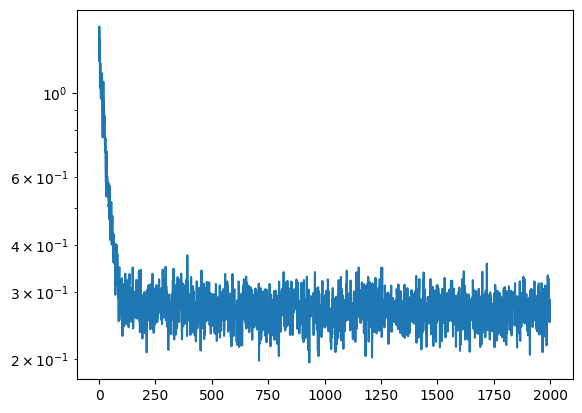

In [16]:
data_batch_size=100
pre_trainer=DPCTrainer(
    batch_size=data_batch_size,
    train_steps=2000,
    horizon_length=5,
    data_gen_sin=dat_gen_sin,
    featurize=featurize_policy,
    policy_optimizer=optimizer,
    ref_loss=mse_loss,
    constr_penalty=penalty_loss,
    ref_loss_weight=1)
keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(data_batch_size,)))

policy_pre,fin_opt_state,fin_keys,losses, val_losses=pre_trainer.fit_on_node(policy, node_grey, motor_env.tau, featurize_node, keys, opt_state)
plt.plot(losses)
plt.yscale('log')

100%|██████████| 15000/15000 [07:05<00:00, 35.27it/s]


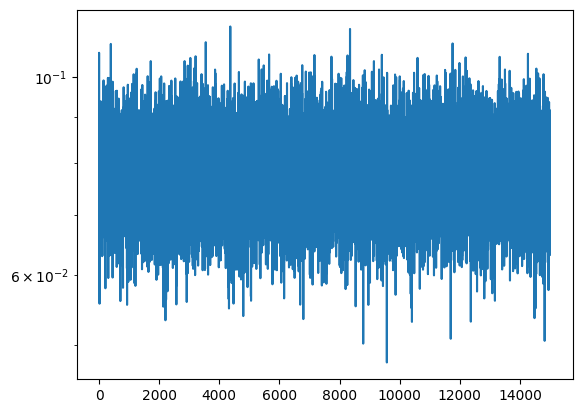

In [17]:
fin_policy_grey,fin_opt_state,fin_keys,losses, val_losses=trainer.fit_on_node(policy_pre, node_grey, motor_env.tau, featurize_node, keys, opt_state)
plt.plot(losses)
plt.yscale('log')

### 2.Example: DPC Training on black

In [18]:
from models.models import NeuralEulerODE,MLP
jax_key = jax.random.PRNGKey(2)
node_struct=NeuralEulerODE([4,128,128,128,128,2],key=jax_key)
node_black = eqx.tree_deserialise_leaves("final_models/black_box/Model_4_128_1.eqx", node_struct)

100%|██████████| 2000/2000 [00:14<00:00, 139.74it/s]


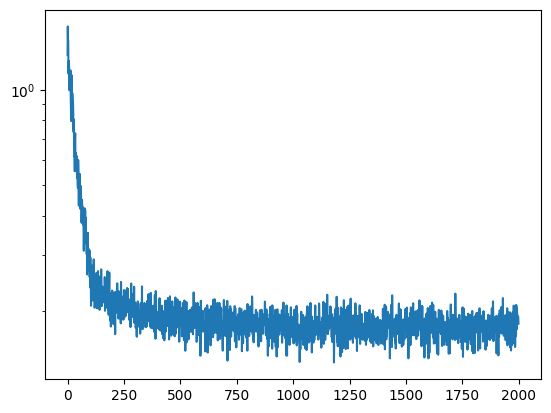

In [19]:
policy_pre_black,fin_opt_state,fin_keys,losses, val_losses=pre_trainer.fit_on_node(policy, node_black, motor_env.tau, featurize_node_black, keys, opt_state)
plt.plot(losses)
plt.yscale('log')

100%|██████████| 15000/15000 [01:48<00:00, 138.19it/s]


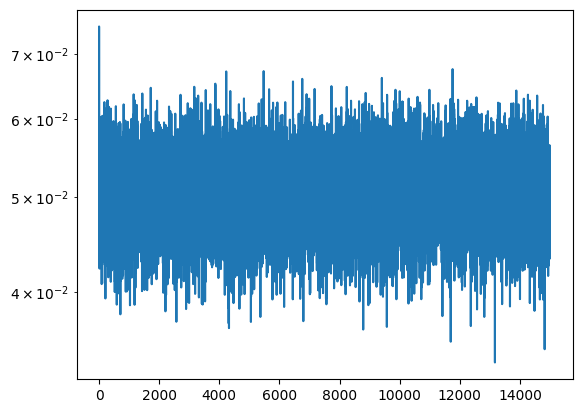

In [20]:
fin_policy_black,fin_opt_state,fin_keys,losses, val_losses=trainer.fit_on_node(policy_pre_black, node_black, motor_env.tau, featurize_node_black, keys, opt_state)
plt.plot(losses)
plt.yscale('log')

In [21]:
from exciting_environments.pmsm.pmsm_env import PMSM,step_eps,dq2albet, ROTATION_MAP
def get_advanced_angle(eps, tau_scale, tau, omega):
    return eps + tau_scale * tau * omega

class ClassicController:
    def __init__(self, motor, saturated, a=4, decoupling=True, tau=1e-4):
        """
        Initializes the ClassicController.

        Args:
            motor (Motor): The motor object containing motor parameters.
            saturated (bool): Indicates whether the motor is saturated.
            a (int, optional): A parameter for the controller. Defaults to 4.
            decoupling (bool, optional): Indicates whether decoupling is enabled. Defaults to True.
            tau (float, optional): The time constant for the controller. Defaults to 1e-4.

        Attributes:
            p_gain (float): Proportional gain for the controller.
            i_gain (float): Integral gain for the controller.
            tau (float): The time constant for the controller.
            a (int): A parameter for the controller.
            motor (Motor): The motor object containing motor parameters.
            L_dq (float): Inductance in the dq-axis (if not saturated).
            psi_dq (float): Flux linkage in the dq-axis (if not saturated).
            batch_size (int): The batch size for processing.
            decoupling (bool): Indicates whether decoupling is enabled.
            saturated (bool): Indicates whether the motor is saturated.
            interpolators (Interpolator): Interpolators for the motor (if saturated).
            u_s_0 (float): Initial control signal.
            integrated (float): Integrated error for the controller.
        """
        self.tau: float = tau
        self.a: int = a

        self.motor= motor
        if not saturated:
            self.L_dq: float = motor.l_dq
            self.psi_dq: float = motor.psi_dq

        self.batch_size: int = None
        self.decoupling: bool = decoupling
        self.saturated: bool = saturated
        if self.saturated:
            self.interpolators = motor.LUT_interpolators
        self.u_s_0 = 0

        self.tune()

    def tune(self):
        """
        Tunes the controller by setting the proportional and integral gains.

        If the motor is not saturated, the proportional gain (p_gain) and integral gain (i_gain)
        are calculated based on the motor's inductance (L_dq), the parameter 'a', and the time constant (tau).

        Returns:
            None
        """
        if not self.saturated:
            self.p_gain = 1 / (self.a * 1.5 * self.tau) * self.L_dq
            self.i_gain = self.p_gain / ((self.a) ** 2 * 1.5 * self.tau)

    def check_constraints(self, e, eps ,integrated, p_gain, i_gain, u_s_0):
        """
        Checks whether operation points are allowed to be integrated and returns a mask.

        The mask indicates whether the operation points are within the allowed constraints.
        A value of 0 indicates "nok" and 1 indicates "ok".

        Args:
            e (np.ndarray): The error array.
            eps (float): The epsilon value.

        Returns:
            np.ndarray: A mask array where 0s indicate not okay and 1s indicate okay.
        """

        mask = jnp.zeros_like(e)
        u_dq = (
            p_gain * e
            + i_gain * (integrated + e * self.tau)
            + u_s_0
        )

        u_dq_norm = u_dq / self.motor.env_properties.action_constraints.u_d

        self.u_albet_norm = dq2albet(
            u_dq_norm,
            get_advanced_angle(eps, 0.5, self.tau, (3 * 1500 / 60 * 2 * jnp.pi)),
        )
        u_albet_c = self.u_albet_norm[:, 0] + 1j * self.u_albet_norm[:, 1]
        idx = (
            jnp.sin(jnp.angle(u_albet_c)[..., jnp.newaxis] - 2 / 3 * jnp.pi * jnp.arange(3))
            >= 0
        ).astype(int)
        rot_vecs = ROTATION_MAP[idx[:, 0], idx[:, 1], idx[:, 2]]
        u_albet_c=jnp.multiply(u_albet_c, rot_vecs)
        cond1 = (jnp.abs(u_albet_c.real) < 2 / 3) & (
            (u_albet_c.imag > 0) & (u_albet_c.imag < 2 / 3 * jnp.sqrt(3))
        )  # Inside
        cond2 = (
            ~(jnp.abs(u_albet_c.real) < 2 / 3)
            | ((u_albet_c.imag < 0) | (u_albet_c.imag > 2 / 3 * jnp.sqrt(3)))
        ) & jnp.all(
            e < 0, axis=1
        )  # outside but neg

        mask = jnp.logical_or(cond1, cond2)
        return mask

    def integrate(self, integrated,e, mask):
        """
        Integrates the error over time with the given mask.

        Args:
            e (np.ndarray): The error array.
            mask (np.ndarray): The mask array indicating which errors to integrate.

        Returns:
            None
        """
        integrated += e * self.tau * mask
        return integrated

    def __call__(self, obs , integrated):
        """
        Computes the control action based on the observed state.

        Args:
            obs (np.ndarray): The observation array containing the normalized state, epsilon, and reference values.

        Returns:
            np.ndarray: The normalized control action voltages.
        """
        # Extract normalized state, epsilon, and reference values from the observation
        state_norm = obs[:, :2]
        eps = obs[:, 2:3]
        reference_norm = obs[:, 3:5]

        # Calculate the error between the reference and the current state
        e = (reference_norm - state_norm) * self.motor.env_properties.physical_constraints.i_d

        if self.saturated:
            # Tune gains if the motor is saturated
            p_d = {
                q: interp(state_norm * self.motor.env_properties.physical_constraints.i_d)
                for q, interp in self.interpolators.items()
            }
            # Neglect non-main-diagonal entries of L_diff
            L_dq = jnp.column_stack([p_d[q] for q in ["L_dd", "L_qq"]])
            psi_dq = jnp.column_stack([p_d[q] for q in ["Psi_d", "Psi_q"]])
            p_gain = 1 / (self.a * 1.5 * self.tau) * L_dq
            i_gain = p_gain / ((self.a) ** 2 * 1.5 * self.tau)

        if self.decoupling:
            # Apply decoupling if enabled
            i_dq = state_norm * self.motor.env_properties.physical_constraints.i_d
            q = jnp.array([0, -1, 1, 0]).reshape(2, 2)
            if self.saturated:
                # Calculate the initial control signal for saturated motor
                u_s_0 = (3 * 1500 / 60 * 2 * jnp.pi) * jnp.einsum(
                    "ij,bj->bi", q, psi_dq
                )
            else:
                # Calculate the initial control signal for non-saturated motor
                u_s_0 = (3 * 1500 / 60 * 2 * jnp.pi) * jnp.einsum(
                    "ij,bj->bi", q, i_dq * L_dq + psi_dq
                )

        # Check constraints and get the integration allowance mask
        integration_allowance_mask = self.check_constraints(e, eps, integrated, p_gain, i_gain, u_s_0)
        # Integrate the error with the mask
        integrated=self.integrate(integrated,e,integration_allowance_mask)
        # Calculate the control action
        u_dq = p_gain * e + i_gain * integrated + u_s_0

        # Normalize the control action voltages
        return u_dq / self.motor.env_properties.action_constraints.u_d, integrated

    def reset(self, batch_size):
        """
        Resets the controller's state for a new batch of data.

        Args:
            batch_size (int): The size of the new batch.

        Returns:
            None
        """
        self.batch_size = batch_size
        
        return jnp.zeros((self.batch_size, 2))

    def parameters(self):
        """
        Returns the parameters of the controller.

        Returns:
            list: An empty list of parameters.
        """
        return []

In [22]:
def pid_control(action):
   #due to use of feature_state as integrated action is already computed in featurize to fit the framework
    return action[0]

In [23]:
controller=ClassicController(motor=motor_env,a=6,saturated=True)
@eqx.filter_jit
def featurize_pid(obs,ref_obs, integrated=jnp.array([[0,0]])):
    eps=jnp.arctan2(obs[5],obs[4])
    i_dq_norm=jnp.array([(obs[0]*0.5-0.5),obs[1]])
    ref_norm=jnp.array([(ref_obs[0]*0.5-0.5),ref_obs[1]])
    feat_obs=jnp.hstack([i_dq_norm,eps,ref_norm])[None,:]
    act,integrated=controller(feat_obs,integrated)
    return act,integrated

## Evaluate on pmsm_env (motor_env):

In [24]:
def eval(policy, featurize):
    obs,obs_ref,acts=steps_eval(motor_env,reset,policy,featurize,jax.random.PRNGKey(2),20000, plot=False)
    return jnp.mean((obs[1:]-obs_ref)**2)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    'font.serif' : 'Computer Modern Roman',
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
}
plt.rcParams.update(tex_fonts)

In [26]:
obs_grey,obs_ref,acts=steps_eval(motor_env,reset,fin_policy_grey,featurize_policy,jax.random.PRNGKey(2),2000,plot=False)

RuntimeError: jaxlib/gpu/solver_kernels.cc:45: operation gpusolverDnCreate(&handle) failed: cuSolver internal error

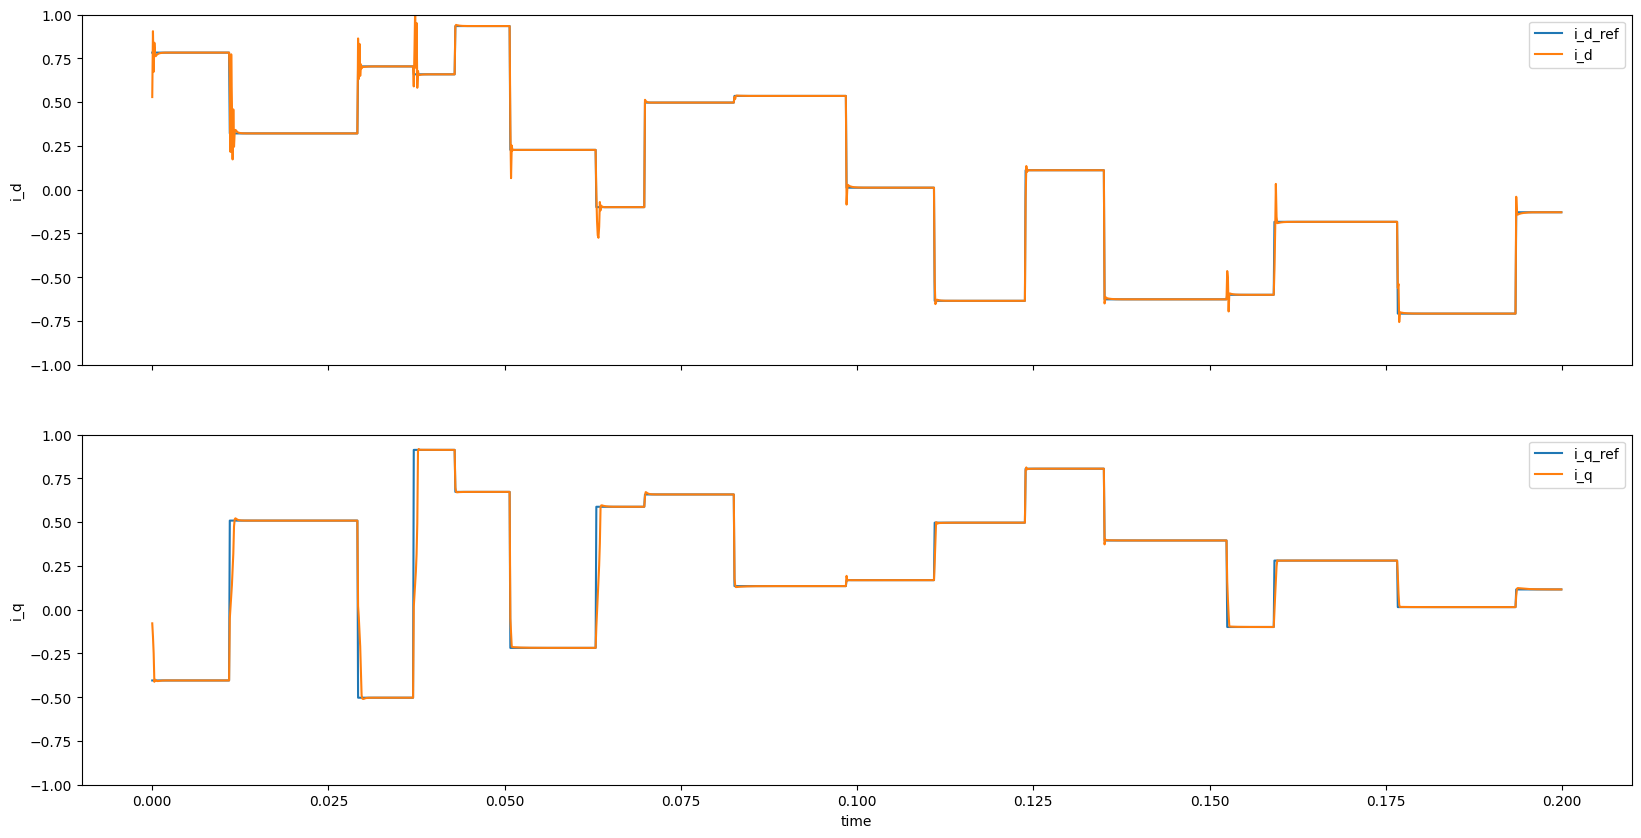

In [ ]:
obs_black,obs_ref,acts=steps_eval(motor_env,reset,fin_policy_black,featurize_policy,jax.random.PRNGKey(2),2000)

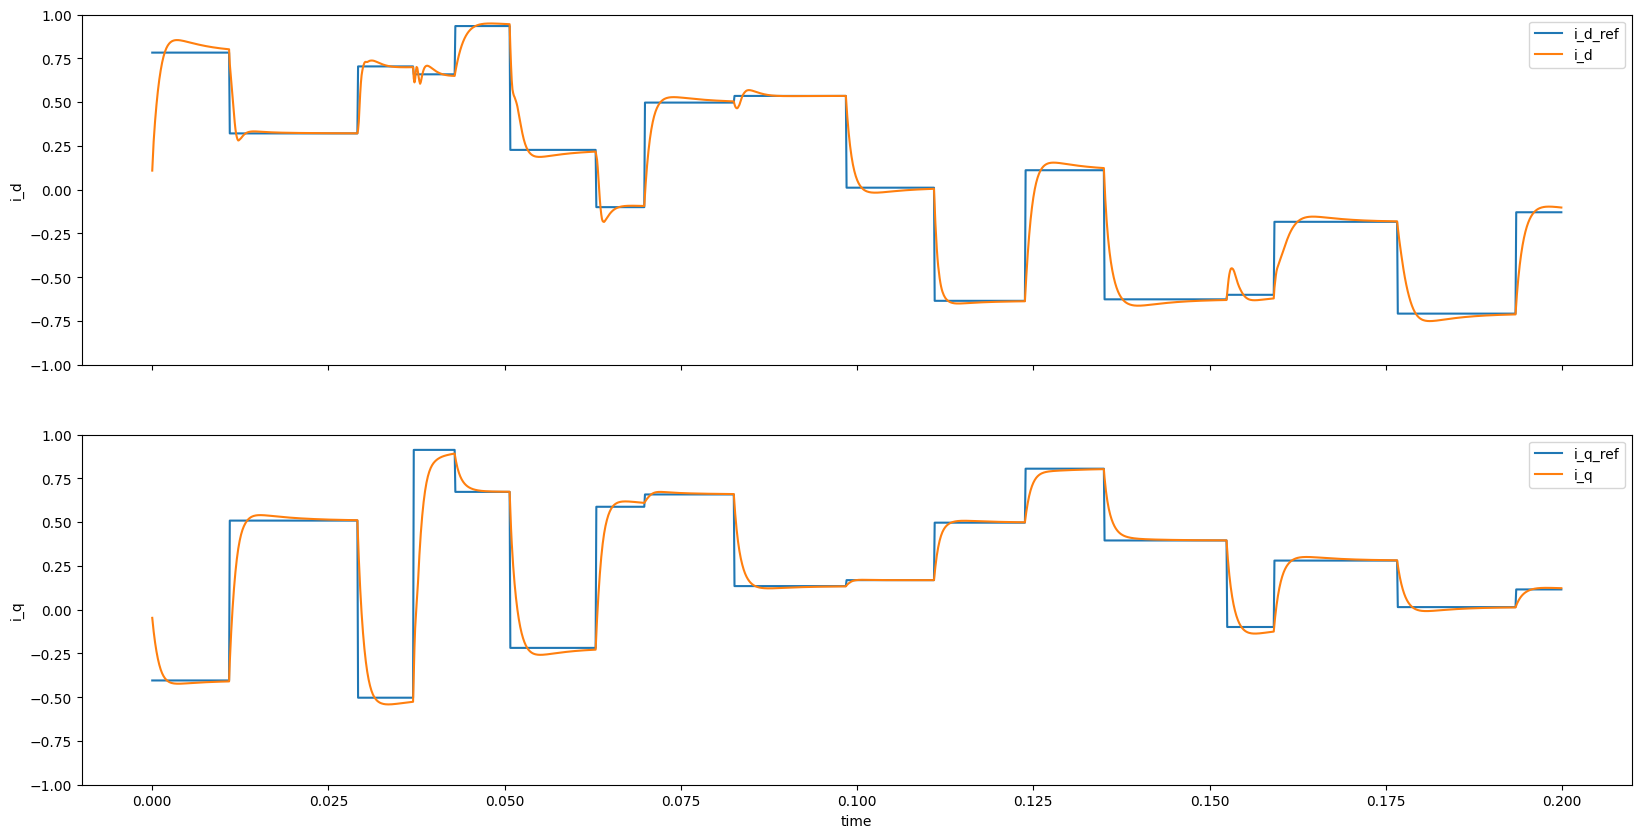

In [ ]:
obs_pid,obs_ref,acts=steps_eval(motor_env,reset,pid_control,featurize_pid,jax.random.PRNGKey(2),2000)

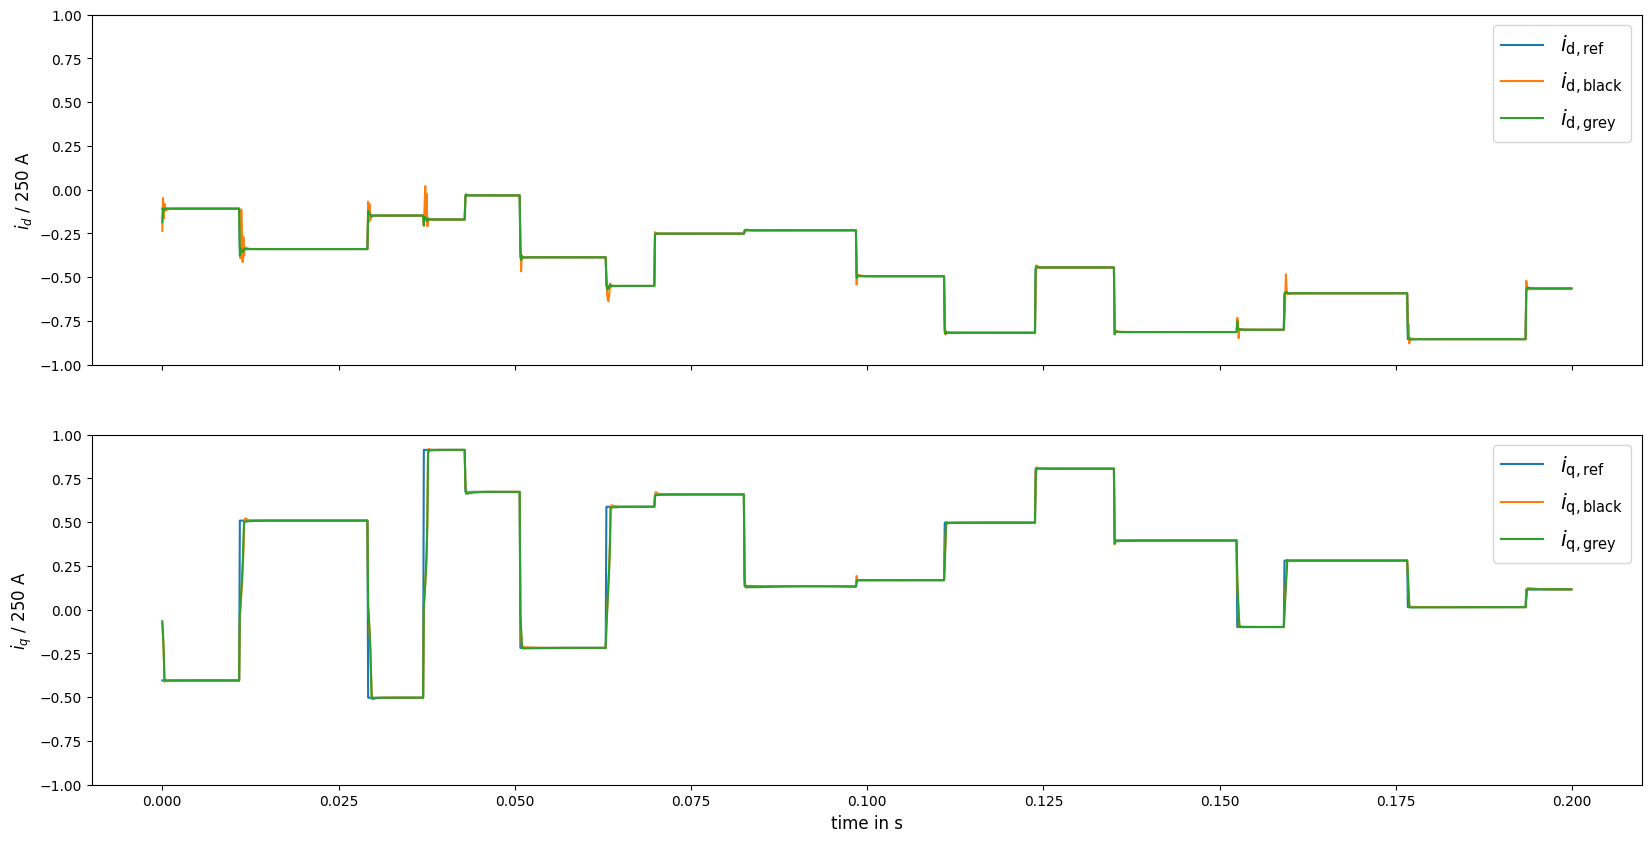

In [52]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
time = jnp.linspace(0, obs_ref.shape[0] - 1, obs_ref.shape[0]) * 1e-4
axes[0].plot(time, obs_ref[:, 0]*0.5 - 0.5, label=r"$i_{\mathrm{d,ref}}$")  # ,label="currents"
axes[0].plot(time, obs_black[1:, 0]*0.5 - 0.5, label=r"$i_{\mathrm{d,black}}$")
axes[0].plot(time, obs_grey[1:, 0]*0.5 - 0.5, label=r"$i_{\mathrm{d,grey}}$")   # ,label="currents"
axes[1].plot(time, obs_ref[:, 1], label=r"$i_{\mathrm{q,ref}}$") 
axes[1].plot(time, obs_black[1:, 1], label=r"$i_{\mathrm{q,black}}$") # ,label="currents"
axes[1].plot(time, obs_grey[1:, 1], label=r"$i_{\mathrm{q,grey}}$")
 #
axes[1].set_ylim(-1, 1)
axes[0].set_ylim(-1, 1)
axes[0].set_ylabel(r"$i_d \text{ / 250 A}$",fontsize=12)
axes[1].set_ylabel(r"$i_q \text{ / 250 A}$",fontsize=12)
axes[1].set_xlabel(r"time in s",fontsize=12)
axes[0].legend(prop={'size': 15})
axes[1].legend(prop={'size': 15})

plt.savefig('pictures/DPC_grey_black.pdf', bbox_inches="tight")


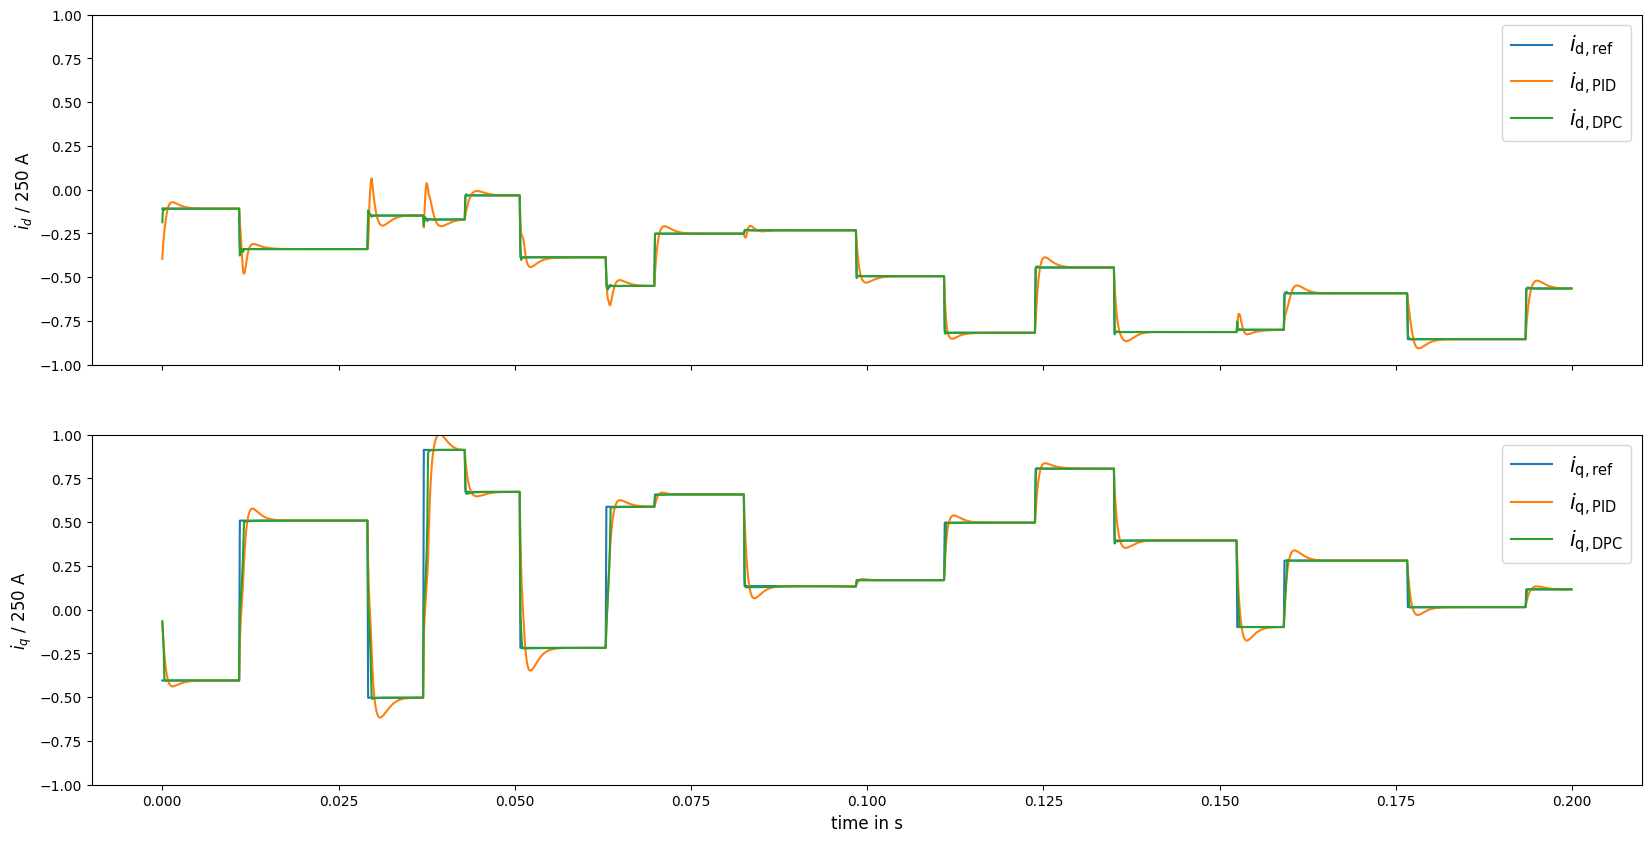

In [51]:
fig, axes = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
time = jnp.linspace(0, obs_ref.shape[0] - 1, obs_ref.shape[0]) * 1e-4
axes[0].plot(time, obs_ref[:, 0]*0.5 - 0.5, label=r"$i_{\mathrm{d,ref}}$")  # ,label="currents"
axes[0].plot(time, obs_pid[1:, 0]*0.5 - 0.5, label=r"$i_{\mathrm{d,PID}}$")
axes[0].plot(time, obs_grey[1:, 0]*0.5 - 0.5, label=r"$i_{\mathrm{d,DPC}}$")   # ,label="currents"
axes[1].plot(time, obs_ref[:, 1], label=r"$i_{\mathrm{q,ref}}$") 
axes[1].plot(time, obs_pid[1:, 1], label=r"$i_{\mathrm{q,PID}}$") # ,label="currents"
axes[1].plot(time, obs_grey[1:, 1], label=r"$i_{\mathrm{q,DPC}}$")
 #
axes[1].set_ylim(-1, 1)
axes[0].set_ylim(-1, 1)
axes[0].set_ylabel(r"$i_d \text{ / 250 A}$",fontsize=12)
axes[1].set_ylabel(r"$i_q \text{ / 250 A}$",fontsize=12)
axes[1].set_xlabel(r"time in s",fontsize=12)
axes[0].legend(prop={'size': 15})
axes[1].legend(prop={'size': 15})

plt.savefig('pictures/DPC_PID.pdf', bbox_inches="tight")

In [15]:
def eval(policy, featurize):
    obs,obs_ref,acts=steps_eval(motor_env,reset,policy,featurize,jax.random.PRNGKey(2),20000, plot=False)
    return jnp.mean((obs[1:]-obs_ref)**2)

In [30]:
mse_grey=eval(fin_policy_grey,featurize_policy)
mse_black=eval(fin_policy_black,featurize_policy)
mse_pid=eval(pid_control,featurize_pid)
print(f"MSE Grey: \n {mse_grey}")
print(f"MSE Black: \n {mse_black}")
print(f"MSE PID: \n {mse_pid}")

MSE Grey: 
 0.25172221660614014
MSE Black: 
 0.25184985995292664
MSE PID: 
 0.2532959580421448


In [16]:
def eval_policy_node(hidden_node,hidden_policy):
    jax_key = jax.random.PRNGKey(2)
    policy=MLP(([8]+hidden_policy+[2]),key=jax_key)
    optimizer = optax.adam(5e-4)
    opt_state = optimizer.init(policy)

    data_batch_size=100
    trainer=DPCTrainer(
        batch_size=data_batch_size,
        train_steps=5000,
        horizon_length=20,
        data_gen_sin=dat_gen_sin,
        featurize=featurize_policy,
        policy_optimizer=optimizer,
        ref_loss=mse_loss,
        constr_penalty=penalty_loss,
        ref_loss_weight=1)
    keys=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(data_batch_size,)))

    data_batch_size=100
    pre_trainer=DPCTrainer(
        batch_size=data_batch_size,
        train_steps=2000,
        horizon_length=5,
        data_gen_sin=dat_gen_sin,
        featurize=featurize_policy,
        policy_optimizer=optimizer,
        ref_loss=mse_loss,
        constr_penalty=penalty_loss,
        ref_loss_weight=1)
    keys_pre=jax.vmap(jax.random.PRNGKey)(np.random.randint(0, 2**31, size=(data_batch_size,)))

    grey_MSEs=[]
    black_MSEs=[]

    for i in range(10):
        jax_key = jax.random.PRNGKey(2)
        node_struct=NeuralEulerODE(([4]+hidden_node+[2]),key=jax_key)
        node_black = eqx.tree_deserialise_leaves(f"final_models/black_box/Model_{len(hidden_node)}_{hidden_node[0]}_{i+1}.eqx", node_struct)
        node_struct= ExpertModel(motor_env=motor_env,psi_layer_sizes=[2]+hidden_node+[2],key=jax_key)
        node_grey = eqx.tree_deserialise_leaves(f"final_models/grey_box/Model_{len(hidden_node)}_{hidden_node[0]}_{i+1}.eqx", node_struct)

        policy_pre_grey,_,_,_,_=pre_trainer.fit_on_node(policy, node_grey, motor_env.tau, featurize_node, keys_pre, opt_state)
        fin_policy_grey,_,_,_,_=trainer.fit_on_node(policy_pre_grey, node_grey, motor_env.tau, featurize_node, keys, opt_state)

        policy_pre_black,_,_,_, _=pre_trainer.fit_on_node(policy, node_black, motor_env.tau, featurize_node_black, keys_pre, opt_state)
        fin_policy_black,_,_,_, _=trainer.fit_on_node(policy_pre_black, node_black, motor_env.tau, featurize_node_black, keys, opt_state)
        mse_grey=eval(fin_policy_grey,featurize_policy)
        mse_black=eval(fin_policy_black,featurize_policy)
        grey_MSEs.append(mse_grey)
        black_MSEs.append(mse_black)

        _,_,_=steps_eval(motor_env,reset,fin_policy_grey,featurize_policy,jax.random.PRNGKey(2),2000)
        plt.show()
        _,_,_=steps_eval(motor_env,reset,fin_policy_black,featurize_policy,jax.random.PRNGKey(2),2000)
        plt.show()

    return grey_MSEs,black_MSEs



100%|██████████| 5000/5000 [00:36<00:00, 136.02it/s]


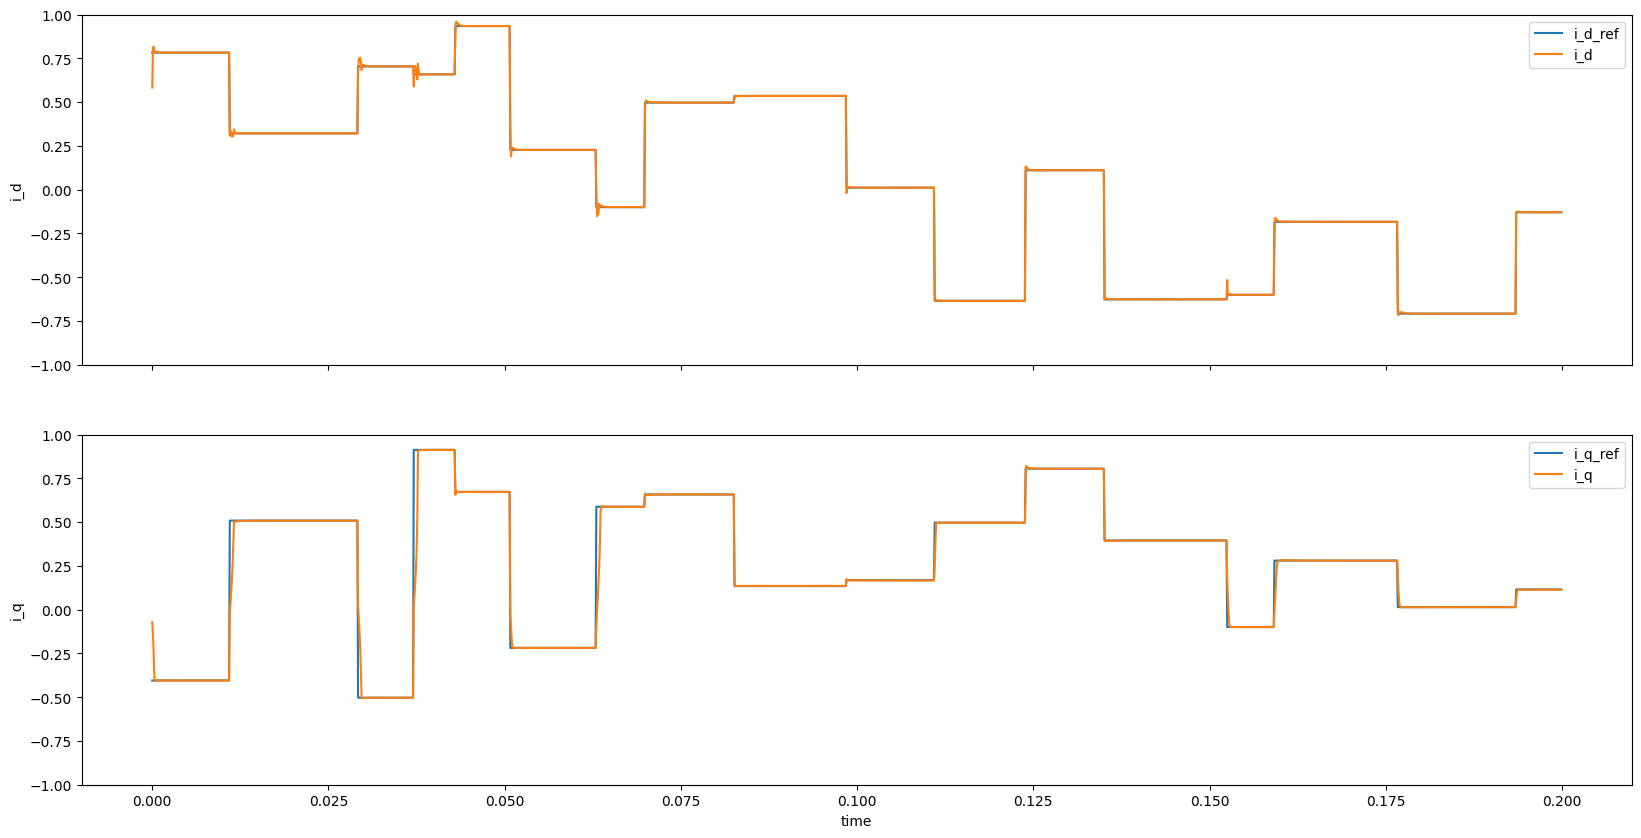

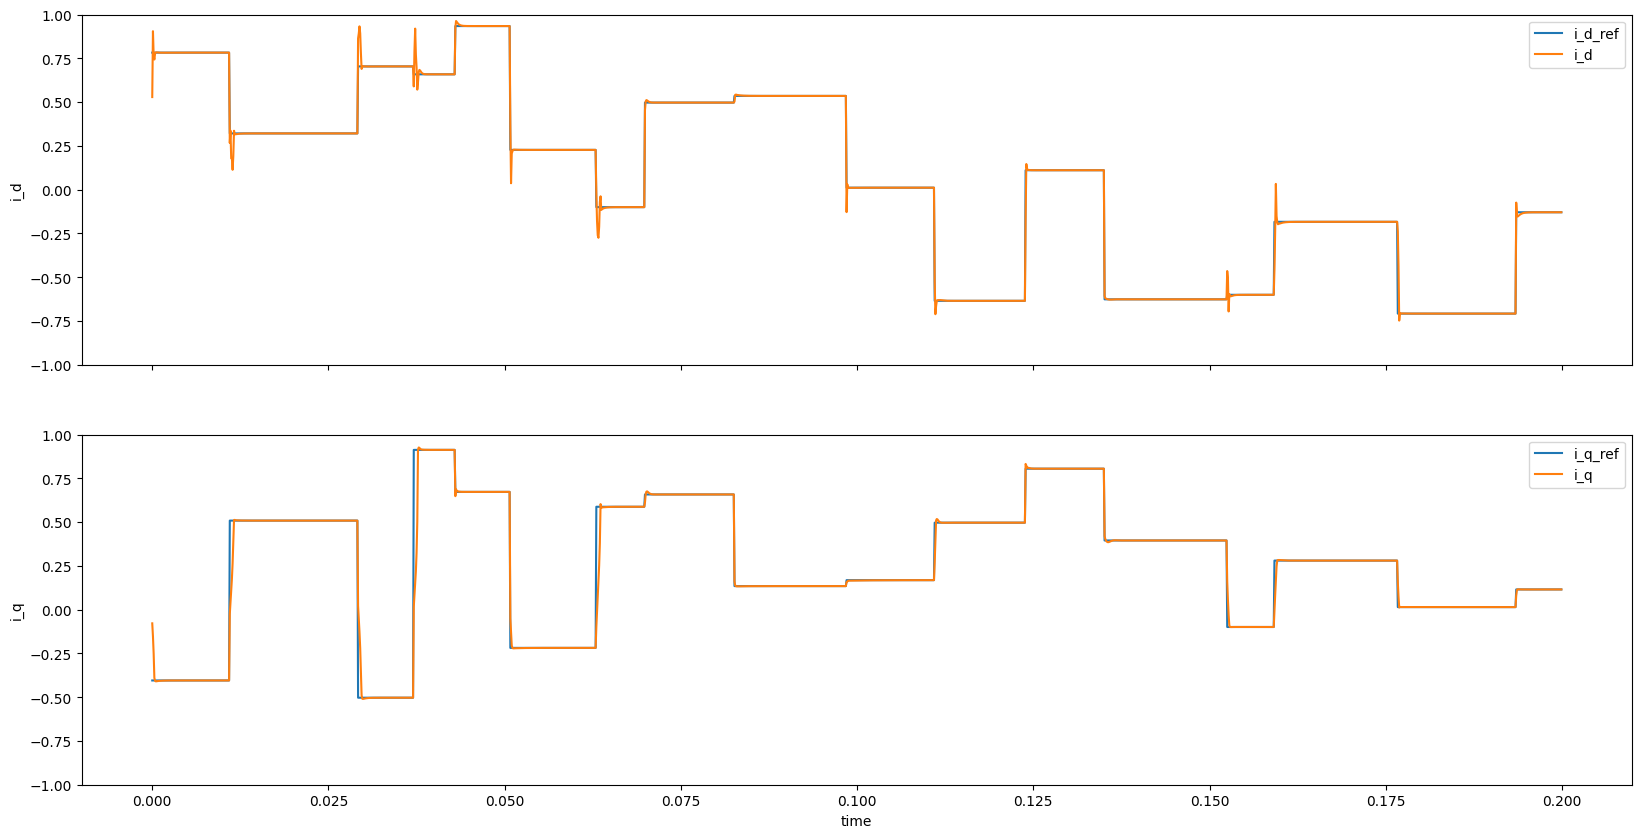

 68%|██████▊   | 3409/5000 [01:15<00:35, 45.42it/s]


KeyboardInterrupt: 

In [17]:
grey_MSEs,black_MSEs= eval_policy_node(hidden_node=[64,64,64],hidden_policy=[64,64])

In [31]:
jnp.mean(jnp.array(black_MSEs))

Array(0.25203085, dtype=float32)

In [32]:
jnp.mean(jnp.array(grey_MSEs))

Array(0.2517247, dtype=float32)

[64,64,64] \
MSE Grey:
 >0.25172269344329834 

MSE Black: 
 >0.25181645154953003 

MSE PID: 
 >0.2532959580421448 

[32,32] \
MSE Grey: 
 >0.2517242729663849

MSE Black: 
 >0.25183865427970886

MSE PID: 
 >0.2532959580421448